In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import scipy.stats as sts
from datetime import datetime
import plotly.express as px
import os

directory = 'data'

# Plotting Methods

In [43]:
def plotly_linechart(df, x_col, y_col, xtitle, ytitle, title, subtitle, color=None, yaxis=False):
    autorange = "reversed" if yaxis else True
    
    fig = px.line(df, x=x_col, y=y_col,color=color,
                  title=f'{title}<br><sup>{subtitle}</sup>',
                  labels={x_col: xtitle,y_col: ytitle}
                  )
    fig.update_yaxes(autorange=autorange)
    fig.update_layout(
        autosize=False,
        width=1600,
        height=600,
    )
    return fig

def plotly_barchart(df, x_col, y_col, xtitle, ytitle,  title, subtitle, color=None):
    fig = px.bar(df, x=x_col, y=y_col, color=color,
                 title=f'{title}<br><sup>{subtitle}</sup>',
                 labels={x_col: xtitle,y_col: ytitle},
                 barmode="group")
    fig.update_layout(
        autosize=False,
        width=1600,
        height=600,
    )
    return fig

def plotly_piechart(df, val, names, title, subtitle, color=None):
    fig = px.pie(df, values=val, names=names, color=color, title=f'{title}<br><sup>{subtitle}</sup>')
    fig.update_layout(
        autosize=False,
        width=1600,
        height=600,
    )
    return fig

def plotly_histogram(df, values, title, subtitle, nbins=100, color=None):
    fig = px.histogram(df, x=values, nbins= nbins, color=color, title=f'{title}<br><sup>{subtitle}</sup>', text_auto=True)
    fig.update_layout(
        autosize=False,
        width=1600,
        height=600,
    )
    return fig

# 1 Dataset Preprocessing

### 1.1 Drivers, Constructors & Circuits

In [44]:
drivers = pd.read_csv(os.path.join(directory,'drivers.csv')).replace('\\N', np.nan)
drivers['fullName'] = drivers['forename'] + ' ' + drivers['surname']
drivers['dob'] = drivers['dob'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

constructors = pd.read_csv(os.path.join(directory,'constructors.csv')).replace('\\N', np.nan).rename(columns={'name': 'constructorName', 'url': 'constructorURL', 'nationality': 'constructorNationality'})

circuits = pd.read_csv(os.path.join(directory,'circuits.csv')).rename(columns={'name': 'circuitName', 'url': 'circuitURL'}).replace('\\N', np.nan)

### 1.2 Races & Results

In [45]:
from datetime import datetime

races = pd.read_csv(os.path.join(directory,'races.csv')).replace('\\N', np.nan).rename(columns={'name': 'raceName', 'url': 'raceURL'})

date_cols = [x for x in races.columns if x.find('date') != -1]
time_cols = [x.replace('date', 'time') for x in date_cols]
date_time_cols = [(x,y) for x,y in zip(date_cols, time_cols)]

for (date,time) in date_time_cols:
    mod_date = date
    if time[0] != 't':
        mod_date = date.split('_')[0] + 'Datetime'
    if date[0] == 'd':
        mod_date = 'race' + 'Datetime'

    races[f'{mod_date}'] = races[date] + " " + races[time]
    races[f'{mod_date}'] = races[f'{mod_date}'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') if pd.notna(x) else np.nan)

races = races.drop(columns=date_cols + time_cols)

results = pd.read_csv(os.path.join(directory,'results.csv')).replace('\\N', np.nan)
results = results.merge(races[['raceId','year', 'raceName', 'raceDatetime']], how='inner', on='raceId')

### 1.4 Lap Times

In [46]:
def laptime2seconds(laptime):
    if isinstance(laptime, str):
        (mins, sec) = laptime.split(':')[-2:]
        (sec, ms) = sec.split('.')
        return 60*float(mins) + float(sec) + float(f'0.{ms}')
    return laptime

In [47]:
laps = pd.read_csv(os.path.join(directory,'lap_times.csv')).replace('\\N', np.nan).rename(columns={'time': 'laptime', 'milliseconds': 'laptime_ms'})
laps = laps.merge(races[['raceId', 'circuitId', 'year', 'round', 'raceName' ,'raceDatetime']], how='inner', on='raceId')
laps = laps.merge(drivers[['driverId', 'code', 'fullName', 'dob','nationality']], how='inner', on='driverId')
laps = laps.merge(circuits[['circuitId', 'circuitName', 'location', 'country', 'lat', 'lng', 'alt']], how='inner', on='circuitId')

laps.year.sort_values().unique()


array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023])

In [48]:
qualifying = pd.read_csv(os.path.join(directory,'qualifying.csv')).replace('\\N', np.nan)
qualifying = qualifying.merge(races[['raceId', 'circuitId', 'year', 'round', 'raceName' ,'raceDatetime']], how='inner', on='raceId')
qualifying = qualifying.merge(drivers[['driverId', 'code', 'fullName', 'dob','nationality']], how='inner', on='driverId')
qualifying = qualifying.merge(circuits[['circuitId', 'circuitName', 'location', 'country', 'lat', 'lng', 'alt']], how='inner', on='circuitId')
qualifying = qualifying.merge(constructors[['constructorId', 'constructorName']], how='inner', on='constructorId')

for col in ['q1','q2', 'q3']:
    qualifying[f'secLaptime{col.capitalize()}'] = qualifying[col].apply(laptime2seconds)
    # tmp = qualifying.groupby(['raceId']).agg(bestLap=pd.NamedAgg(f'{col}Laptime', 'min'))

session_aggregation = qualifying.groupby(['raceId']).agg(bestLaptimeQ1=pd.NamedAgg('secLaptimeQ1', 'min'), bestLaptimeQ2=pd.NamedAgg('secLaptimeQ2', 'min'), bestLaptimeQ3=pd.NamedAgg('secLaptimeQ3', 'min'))

qualifying = qualifying.merge(session_aggregation, how='inner', on='raceId')

for col in ['q1','q2', 'q3']:
    qualifying[f'bestTimeDelta{col.capitalize()}'] = (qualifying[f'secLaptime{col.capitalize()}'] - qualifying[f'bestLaptime{col.capitalize()}'])


In [49]:
drivers_qualifying = qualifying.groupby(['fullName', 'year']).agg(appeareancesQ1=pd.NamedAgg('q1', pd.Series.dropna),
                                                                                      appeareancesQ2=pd.NamedAgg('q2', pd.Series.dropna),
                                                                                      appeareancesQ3=pd.NamedAgg('q3', pd.Series.dropna),
                                                                                      avgSessionDeltaQ1=pd.NamedAgg('bestTimeDeltaQ1', 'mean'),
                                                                                      avgSessionDeltaQ2=pd.NamedAgg('bestTimeDeltaQ2', 'mean'),
                                                                                      avgSessionDeltaQ3=pd.NamedAgg('bestTimeDeltaQ3', 'mean'),
                                                                                      avgResultQualifying=pd.NamedAgg('position', 'mean'),
                                                                                      bestResultQualifying=pd.NamedAgg('position', 'min'),
                                                                                      worstResultQualifying=pd.NamedAgg('position', 'max'),
                                                                                      ).reset_index()

for col in ['q1','q2', 'q3']:
    drivers_qualifying[f'appeareances{col.capitalize()}'] = drivers_qualifying[f'appeareances{col.capitalize()}'].apply(lambda x: len(x))

In [50]:
status = pd.read_csv(os.path.join(directory,'status.csv'))

# 2 Project Visualisation Ideas

In [51]:
plot_directory = 'img/milestone1-plots'

In [52]:
sample = laps[laps.raceId == 1035].copy()
sample['laptime_s'] = sample['laptime_ms'] / 1000

fig = plotly_linechart(sample, 
                 x_col="lap", 
                 y_col="position", 
                 xtitle="Lap", 
                 ytitle="Position", 
                 color="fullName", 
                 title="Race Evolution - Positional Changes Across Laps", 
                 subtitle=f"Race: {sample.location.iloc[0]} - {sample.raceName.iloc[0]} {sample.year.iloc[0]}. Comment: Max Verstappen won the race. Kevin Magnussen retired at lap 43. Six drivers were lapped by the leader.", 
                 yaxis=True)

fig.show()
fig.write_image(os.path.join(plot_directory, "testViz_raceEvolution2020.webp"))

In [53]:
driver_laptimes = sample[(sample.fullName.isin(['Max Verstappen', 'Lewis Hamilton', 'Charles Leclerc', 'Lando Norris']))].copy()

fig = plotly_linechart(driver_laptimes, 
                 x_col="lap", 
                 y_col='laptime_s', 
                 xtitle='Lap', 
                 ytitle='Laptime (s)', 
                 color="fullName", 
                 title="Race Pace Comparison - Selected Drivers", 
                 subtitle=f"Race: {sample.location.iloc[0]} - {sample.raceName.iloc[0]} {sample.year.iloc[0]}. Comment: Max Verstappen won the race through a unique 2-stop strategy.")

fig.show()
fig.write_image(os.path.join(plot_directory, "testViz_racePaceComparison2020.webp"))

In [54]:
sample_drivers = ['Sebastian Vettel', 'Lewis Hamilton', 'Fernando Alonso', 'Kimi Räikkönen']

fig = plotly_barchart(drivers_qualifying[drivers_qualifying.fullName.isin(sample_drivers)],
                 x_col='year',
                 y_col='avgResultQualifying',
                 xtitle='Year',
                 ytitle='AVG Qualifying Position',
                 color='fullName',
                 title="Seasonal Average Qualifying Position - Selected Drivers",
                 subtitle=f'Sebastian Vettel achieved an avg. qualifying position of 1.26 in 2011 by taking pole in 15 of 19 races. Lewis Hamilton have achieved a avg. qualifying position <5 in 14 of 17 seasons.')

fig.show()
fig.write_image(os.path.join(plot_directory, "testViz_selectedDriversAvgPosQualifying.webp"))

# 3 Dataset Exploration

In [55]:
results = pd.read_csv(os.path.join(directory, 'results.csv')).replace('\\N', np.nan)

results = results.merge(races[['raceId','raceName', 'raceDatetime', 'year', 'round', 'circuitId']], how='inner', on='raceId')
results = results.merge(constructors[['constructorId','constructorName', 'constructorNationality']], how='inner', on='constructorId')
results = results.merge(drivers[['driverId','fullName', 'nationality', 'code', 'dob']], how='inner', on='driverId')
results = results.merge(status, how='inner', on='statusId')

## Seasonal Statistics

In [56]:
seasonal_statistics = results.groupby('year').agg(races=pd.NamedAgg('raceId', pd.Series.nunique),
                                                  drivers=pd.NamedAgg('driverId', pd.Series.nunique),
                                                  teams=pd.NamedAgg('constructorId', pd.Series.nunique),
                                                  total_points=pd.NamedAgg('points', 'sum'),
                                                  dnfs=pd.NamedAgg('position', lambda x: x.isna().sum()),
                                                  min_datetime=pd.NamedAgg('raceDatetime', 'min'),
                                                  max_datetime=pd.NamedAgg('raceDatetime', 'max'),
                                                  nationalities=pd.NamedAgg('nationality', pd.Series.nunique),
                                                  )

seasonal_statistics['drivers/team'] = seasonal_statistics['drivers'] / seasonal_statistics['teams']
seasonal_statistics['points/race'] = seasonal_statistics['total_points'] / seasonal_statistics['races']
seasonal_statistics['seasonal_length_days'] = (seasonal_statistics['max_datetime'] - seasonal_statistics['min_datetime']).dt.days
seasonal_statistics['mean_days_between_races'] = seasonal_statistics['seasonal_length_days'] / seasonal_statistics['races']


seasonal_statistics = seasonal_statistics.reset_index()

### Races per Season

In [57]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='races',
                 xtitle='Year',
                 ytitle='Races',
                 title='Formula 1 Races per Season (1950-2023)',
                 subtitle='F1 seasons have become longer in terms of number of races. Note: incomplete data for 2023 -> should be 22 races.')

fig.show()
fig.write_image(os.path.join(plot_directory, "stats_perSeasonRaces.webp"))

### Season Length in Days

In [58]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='seasonal_length_days',
                 xtitle='Year',
                 ytitle='Seasonal Length (Days)',
                 title='Formula 1 Seasonal Lengths (1950-2023)',
                 subtitle='Seasonal length measured in days from first to last race. Note: the dataset is missing data information for all races before 2005.')

fig.show()
fig.write_image(os.path.join(plot_directory, "stats_seasonalLengths.webp"))

### Teams per Season

In [59]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='mean_days_between_races',
                 xtitle='Year',
                 ytitle='Days',
                 title='Formula 1 AVG Days Between Races (1950-2023)',
                 subtitle='Since 2005, there have been at least one race every second week during the season. Due to covid-19, the 2020 season was delayed to June, thus shortened and compressed, resulting in fewer days between races.'
                 )

fig.show()
fig.write_image(os.path.join(plot_directory, "stats_daysBetweenRaces.webp"))

### Drivers per Season

In [60]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='drivers',
                 xtitle='Year',
                 ytitle='Drivers',
                 title='Formula 1 Drivers per Season (1950-2023)',
                 subtitle='The number of drivers per season have steadily decreased due to fewer teams and less drivers per team on average.'
                 )

fig.show()
fig.write_image(os.path.join(plot_directory, "stats_perSeasonDrivers.webp"))

### Drivers / Team

In [61]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='drivers/team',
                 xtitle='Year',
                 ytitle='Drivers/Team',
                 title='Formula 1 Drivers/Team per Season (1950-2023)',
                 subtitle='There have been 2-3 drivers per team on average since 1974 (exept 1994).'
                 )

fig.show()
fig.write_image(os.path.join(plot_directory, "stats_perSeasonDriversPerTeam.webp"))

### Points per Season

In [62]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='total_points',
                 xtitle='Year',
                 ytitle='Total Points',
                 title='Formula 1 Total Points per Season (1950-2023)',
                 subtitle='Extended race calendars and minor changes to point system caused increase in total points prior to 2009. Major overhaul to the point system in 2010 caused explosive increase in total points per season.'
                 )
fig.show()
fig.write_image(os.path.join(plot_directory, "stats_perSeasonPoints.webp"))

### DNFs per Season

In [63]:
fig = plotly_linechart(seasonal_statistics,
                 x_col='year',
                 y_col='dnfs',
                 xtitle='Year',
                 ytitle='DNFs',
                 title='Formula 1 DNFs per Season (1950-2023)',
                 subtitle='In spite of longer race calendars in recent years, the number of DNFs have decreased, perhaps suggesting improved reliability.'
                 )

fig.show()
fig.write_image(os.path.join(plot_directory, "stats_perSeasonDNFs.webp"))

In [64]:
dnf_causes = [x for x in results.positionText.unique() if not x.isnumeric()]
dnf = results[results.positionText.isin(dnf_causes)].groupby('status').size().sort_values(ascending=False).reset_index(name='count')

relevant_frac = dnf[dnf['count'] > 50].shape[0] / dnf.shape[0]

fig = plotly_barchart(dnf[dnf['count'] > 50],
                 x_col='status',
                 y_col='count',
                 xtitle='Cause of DNF',
                 ytitle='Count',
                 title="Formula 1 Causes of DNF since 1950",
                 subtitle=f'The most common causes of DNFs are engine failure, accident, collisions and gearbox failures. "Did not qualify/prequalify" was caused by old ruleset where cars had to prequalify for qualifying + maximum delta to compete in race.')

fig.show()
fig.write_image(os.path.join(plot_directory, "dist_causedOfDNF.webp"))

## Distributional Statistics

### Dataset Driver Nationalities

In [65]:
drivers_nationality = drivers.groupby('nationality').agg(count=pd.NamedAgg('nationality', 'size'),
                                                         names=pd.NamedAgg('fullName', pd.Series.unique)).sort_values('count', ascending=False).reset_index()

drivers_nationality['proportion'] = drivers_nationality['count'] / drivers.shape[0]
drivers_nationality['cumulative_proportion'] = drivers_nationality['proportion'].cumsum()
drivers_nationality = drivers_nationality.reset_index(drop=False, names='rank')
drivers_nationality['rank'] += 1

top10_nationalities = drivers_nationality[['nationality', 'count', 'cumulative_proportion']].iloc[:10]
top10_nationalities = pd.concat([top10_nationalities, pd.DataFrame([{'nationality': 'Other',
                                                                    'count': drivers.shape[0] - top10_nationalities['count'].sum(),
                                                                    'cumulative_proportion': 1 - top10_nationalities.iloc[9]['cumulative_proportion']}])])

fig = plotly_piechart(top10_nationalities,
                val='count',
                names='nationality',
                title=f"Driver's Nationalities",
                subtitle=f"Top 10 Nationalities accounts for {round(drivers_nationality.iloc[9]['cumulative_proportion'], 3) * 100}% of the drivers that have raced in Formula 1 since 1950. There have been most british, american and italian drivers in F1.")

fig.show()
fig.write_image(os.path.join(plot_directory, "dist_pieTopDriversNationalities.webp"))



In [66]:
plotly_linechart(drivers_nationality, 
                 x_col='rank', 
                 y_col='cumulative_proportion',  
                 xtitle='Top K Nationalities', 
                 ytitle='Proportion', 
                 title="Cumulative Fraction - Top K Driver's Nationalities in Formula 1", 
                 subtitle="Aggregated from 'drivers.csv'")

### Driver Histograms

In [67]:
driver_statistics = results.groupby('driverId').agg(dob=pd.NamedAgg('dob', 'min'),
                                                    first_race=pd.NamedAgg('raceDatetime', 'min'),
                                                    last_race=pd.NamedAgg('raceDatetime', 'max'),
                                                    seasons=pd.NamedAgg('year', pd.Series.nunique),
                                                    races=pd.NamedAgg('raceId', pd.Series.nunique),
                                                    total_points=pd.NamedAgg('points', 'sum'),
                                                    dnfs=pd.NamedAgg('position', lambda x: x.isna().sum()),
                                                    )

driver_statistics = driver_statistics.reset_index()

In [68]:
relevant_frac = driver_statistics[driver_statistics.seasons > 3].shape[0] / driver_statistics.shape[0]

fig = plotly_histogram(driver_statistics, 
                 values='seasons', 
                 title='Formula 1 Seasons per Driver', 
                 subtitle=f'{round(relevant_frac*100, 2)}% of the {driver_statistics.shape[0]} drivers that have raced in Formula 1 got to race for more than 3 seasons. Only one driver have raced 20 seasons.', 
                 nbins=20)

fig.show()
fig.write_image(os.path.join(plot_directory, "dist_histogramSeasonsPerDriver.webp"))

In [69]:
relevant_frac = driver_statistics[driver_statistics.races > 20].shape[0] / driver_statistics.shape[0]

fig = plotly_histogram(driver_statistics, 
                 values='races', 
                 title='Formula 1 Races per Driver', 
                 subtitle=f'Only {round(relevant_frac*100, 2)}% of the {driver_statistics.shape[0]} drivers that have raced in Formula 1 got to race for more than 20 races (approximately 1 race calendar in recent years).', 
                 nbins=30)

fig.show()
fig.write_image(os.path.join(plot_directory, "dist_histogramRacesPerDriver.webp"))

In [70]:
filtered_ds = driver_statistics.dropna().copy()
filtered_ds['debut_age'] = ((filtered_ds['first_race'] - filtered_ds['dob']) / pd.Timedelta(days=365.25)).astype(int)
filtered_ds['retiring_age'] = ((filtered_ds['last_race'] - filtered_ds['dob']) / pd.Timedelta(days=365.25)).astype(int)

relevant_frac = filtered_ds[(filtered_ds.debut_age > 20) & (filtered_ds.debut_age < 25)].shape[0] / filtered_ds.shape[0]

fig = plotly_histogram(filtered_ds, 
                 values='debut_age', 
                 title='Formula 1 Debut Age', 
                 subtitle=f'We have debut age for {filtered_ds.shape[0]} drivers. {round(relevant_frac*100, 2)}% of them debuted at age between 20 and 25', nbins=20)

fig.show()
fig.write_image(os.path.join(plot_directory, "dist_histogramDebutAge.webp"))

In [71]:
relevant_frac = filtered_ds[filtered_ds.debut_age < 30].shape[0] / filtered_ds.shape[0]
fig = plotly_histogram(filtered_ds, 
                 values='retiring_age', 
                 title='Formula 1 Debut Age', 
                 subtitle=f'We have age of last race for {filtered_ds.shape[0]} drivers. {round(relevant_frac*100, 2)}% of them completed their last race before age of 30.', 
                 nbins=20)

fig.show()
fig.write_image(os.path.join(plot_directory, "dist_histogramLastRaceAge.webp"))

# 4 FastF1 Testing

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import fastf1 as f1
import fastf1.plotting as f1plt

f1plt.setup_mpl()

### 4.1 Teammate Comparison

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '77', '5', '3', '27', '55', '23', '18', '7', '99', '20', '26', '4', '10', '8', '11', '63', '88', '33']


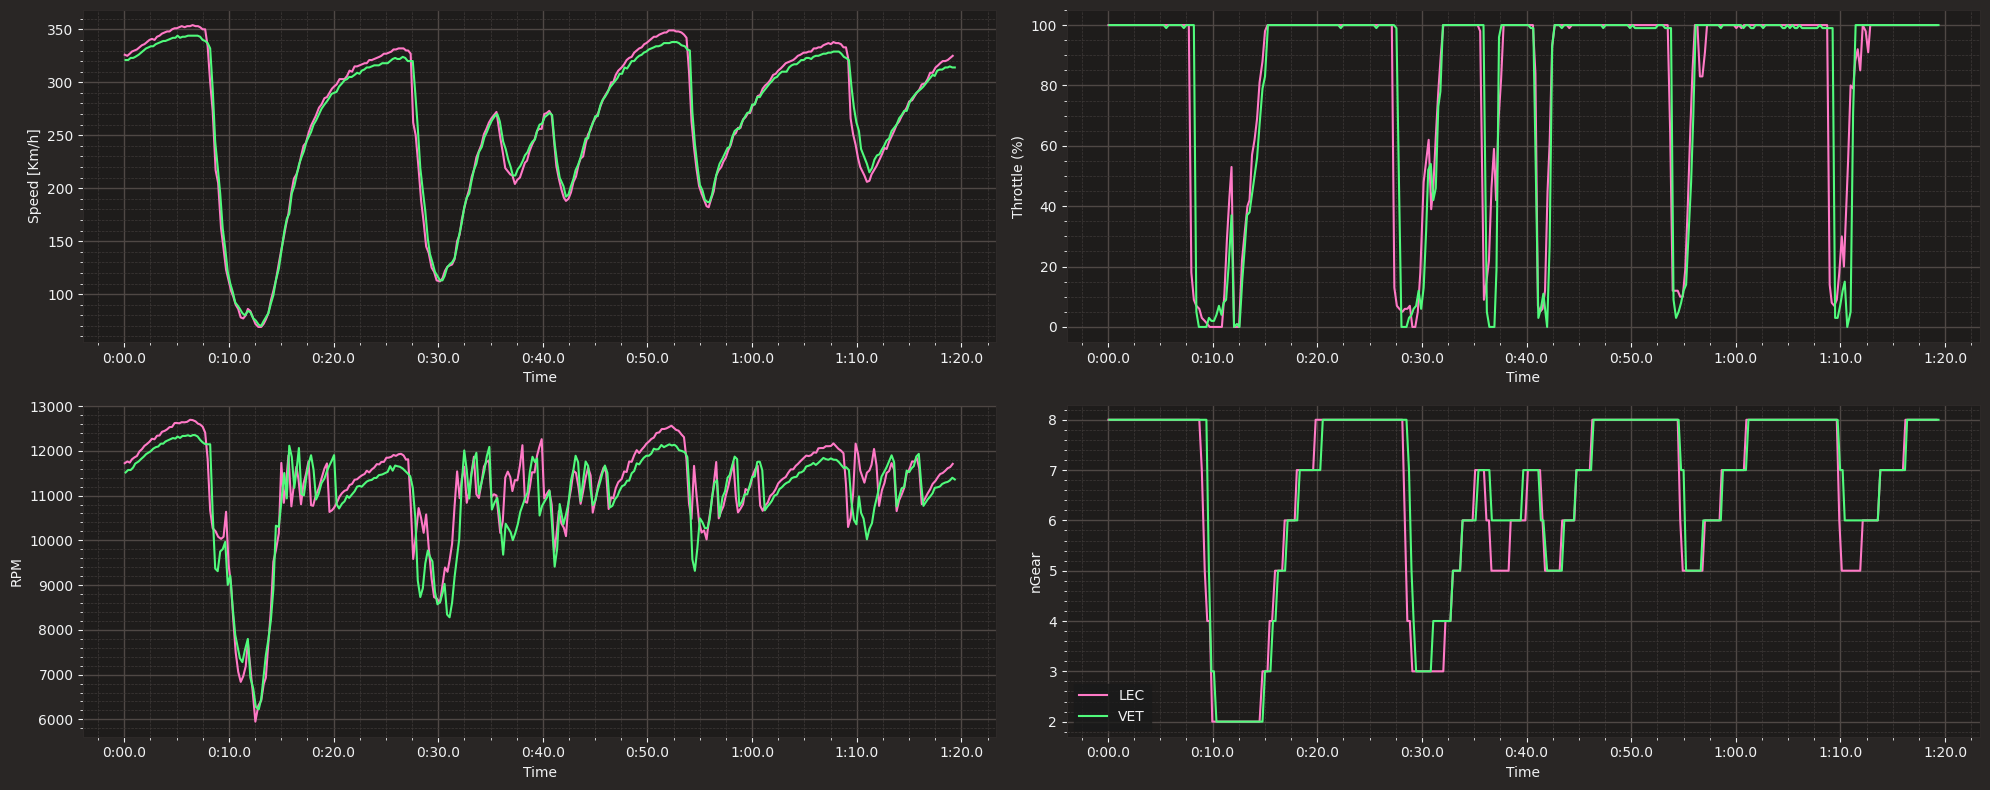

In [73]:
session = f1.get_session(2019, 'Monza', 'Q')
session.load()

lec_fastest = session.laps.pick_driver('LEC').pick_fastest()
vet_fastest = session.laps.pick_driver('VET').pick_fastest()

# Assuming lec_fastest.get_car_data() and vet_fastest.get_car_data() give you dictionaries with 'Time', 'Speed', and other keys
lec_car_data = lec_fastest.get_car_data()
vet_car_data = vet_fastest.get_car_data()

# Use the specific 'Time' arrays for each driver
lec_time = lec_car_data['Time']
vet_time = vet_car_data['Time']

fig, ax = plt.subplots(2, 2, figsize=(20,8))

# Plot using each driver's specific time array
ax[0,0].plot(lec_time, lec_car_data['Speed'], label='LEC')
ax[0,0].plot(vet_time, vet_car_data['Speed'], label='VET')
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Speed [Km/h]')

ax[0,1].plot(lec_time, lec_car_data['Throttle'], label='LEC')
ax[0,1].plot(vet_time, vet_car_data['Throttle'], label='VET')
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('Throttle (%)')

ax[1,0].plot(lec_time, lec_car_data['RPM'], label='LEC')
ax[1,0].plot(vet_time, vet_car_data['RPM'], label='VET')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('RPM')

ax[1,1].plot(lec_time, lec_car_data['nGear'], label='LEC')
ax[1,1].plot(vet_time, vet_car_data['nGear'], label='VET')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('nGear')

plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'fastf1_teammateComparison2019'))
plt.show()



### 4.2 Laptime Distributions

core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


['55', '16', '4', '81', '11', '18', '22', '14', '27', '20']
['SAI', 'LEC', 'NOR', 'PIA', 'PER', 'STR', 'TSU', 'ALO', 'HUL', 'MAG']
{'LEC': '#dc0000', 'SAI': '#ff8181', 'SHW': '#9c0000', 'VER': '#fcd700', 'PER': '#ffec7b', 'DEN': '#907400', 'PIA': '#ff8700', 'NOR': '#eeb370', 'OWA': '#ee6d3a', 'GAS': '#fe86bc', 'OCO': '#ff117c', 'DOO': '#894667', 'BOT': '#00e701', 'ZHO': '#008d01', 'POU': '#004601', 'DEV': '#1e3d61', 'TSU': '#356cac', 'RIC': '#2b4562', 'LAW': '#2b4562', 'HAD': '#1e6176', 'MAG': '#ffffff', 'HUL': '#cacaca', 'BEA': '#c40000', 'ALO': '#006f62', 'STR': '#00413b', 'DRU': '#2f9b90', 'HAM': '#00d2be', 'RUS': '#24ffff', 'VES': '#00a6ff', 'ALB': '#005aff', 'SAR': '#012564', 'OSU': '#1b3d97'}


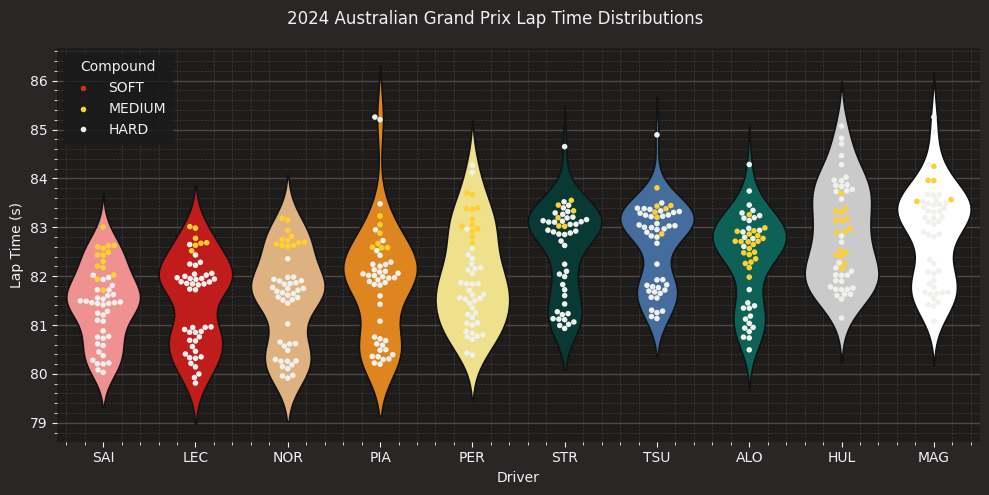

In [74]:
import seaborn as sns
from matplotlib import pyplot as plt

import fastf1
import fastf1.plotting


# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

race = fastf1.get_session(2024, 3, 'R')
race.load(telemetry=False, weather=False)

point_finishers = race.drivers[:10]
print(point_finishers)
driver_laps = race.laps.pick_drivers(point_finishers).pick_quicklaps()
driver_laps = driver_laps.reset_index()

finishing_order = [race.get_driver(i)["Abbreviation"] for i in point_finishers]
print(finishing_order)

driver_colors = {abv: fastf1.plotting.DRIVER_COLORS[driver] for abv,
                 driver in fastf1.plotting.DRIVER_TRANSLATE.items()}
print(driver_colors)

# create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Seaborn doesn't have proper timedelta support
# so we have to convert timedelta to float (in seconds)
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               hue="Driver",
               inner=None,
               density_norm="area",
               order=finishing_order,
               palette=driver_colors
               )

sns.swarmplot(data=driver_laps,
              x="Driver",
              y="LapTime(s)",
              order=finishing_order,
              hue="Compound",
              palette=fastf1.plotting.COMPOUND_COLORS,
              hue_order=["SOFT", "MEDIUM", "HARD"],
              linewidth=0,
              size=4,
              )

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")
plt.suptitle("2024 Australian Grand Prix Lap Time Distributions")
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'fastf1_laptimeDistributions2024'))
plt.show()

### 4.3 Car Performance

core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


Index(['Ferrari', 'McLaren', 'Red Bull Racing', 'Mercedes', 'Aston Martin',
       'Haas F1 Team', 'Alpine', 'RB', 'Kick Sauber', 'Williams'],
      dtype='object', name='Team')


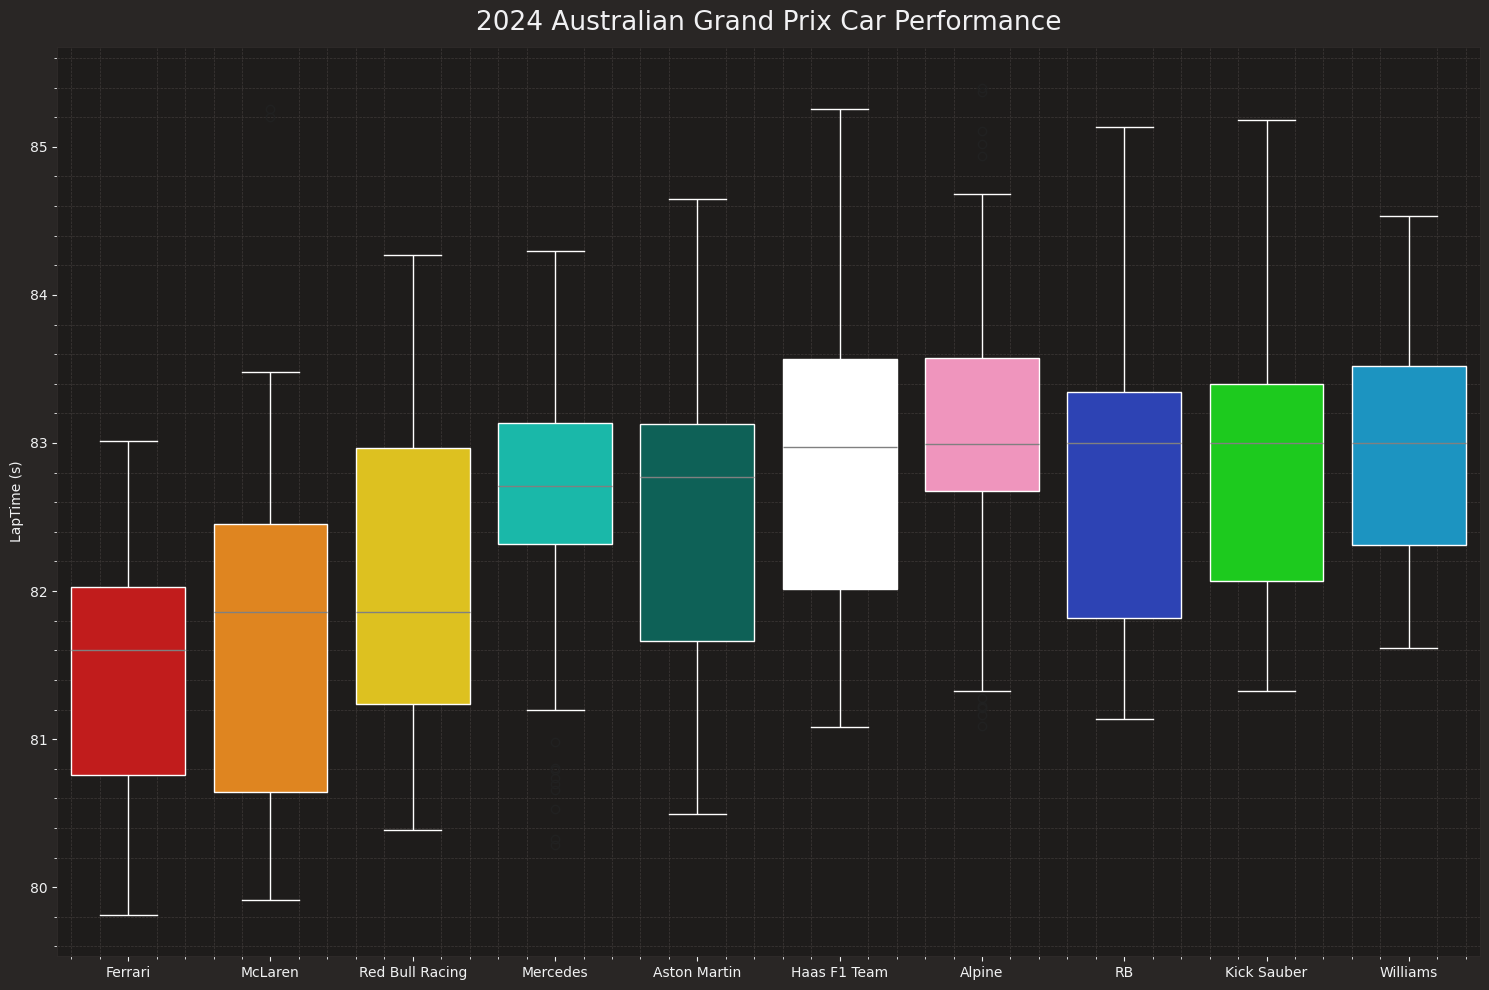

In [75]:
import seaborn as sns
from matplotlib import pyplot as plt

import fastf1
import fastf1.plotting


# activate the fastf1 color scheme (and no other modifications)
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

race = fastf1.get_session(2024, 3, 'R')
race.load(telemetry=False, weather=False)

laps = race.laps.pick_quicklaps()

transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)

# make a color palette associating team names to hex codes
team_palette = {team: fastf1.plotting.team_color(team) for team in team_order}

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
)

plt.title("2024 Australian Grand Prix Car Performance")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'fastf1_carPerformance2024'))
plt.show()